In [162]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader , TensorDataset
import matplotlib.pyplot as plt
#from lstm_cnn_net import LSTM

(236, 301, 12) (190, 301, 12) (24, 301, 12) (22, 301, 12) (190,)


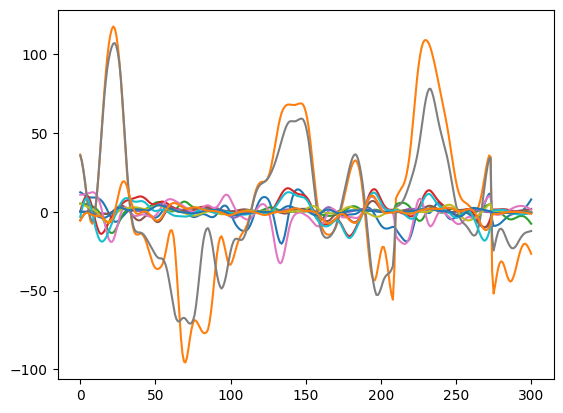

In [163]:
#load data
AC = np.load('C:\Github_LIU\SII2025\process_data\classifier\AC.npy')
AD = np.load('C:\Github_LIU\SII2025\process_data\classifier\AD.npy')
BC = np.load('C:\Github_LIU\SII2025\process_data\classifier\BC.npy')
BD = np.load('C:\Github_LIU\SII2025\process_data\classifier\BD.npy')
#split data into training and testing and validation
X = np.concatenate((AC, AD, BC, BD), axis=0)
AC_labels = [0] * len(AC)
AD_labels = [1] * len(AD)
BC_labels = [2] * len(BC)
BD_labels = [3] * len(BD)
y = np.concatenate((AC_labels, AD_labels, BC_labels, BD_labels), axis=0)
#归一化
def min_max_normalize(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    range_val = max_val - min_val
    range_val[range_val == 0] = 1  # 防止除零错误
    return (data - min_val) / range_val
#X = min_max_normalize(X)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)
print(X.shape,X_train.shape, X_test.shape, X_val.shape,y_train.shape)
#draw X_train
plt.plot(X_train[7])
plt.show()

batch_size = 22
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_data = TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [164]:
#define hyperparameters
sequence_len = 301
input_len = 12
hidden_size = 128
num_layers = 2
num_classes = 4
num_epochs = 100
learning_rate = 0.01

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [166]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        #LSTM
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        #CNN
        self.conv1 = nn.Conv1d(12, 64, 9)
        self.conv2 = nn.Conv1d(64, 32, 5)
        self.conv3 = nn.Conv1d(32, 32, 5)
        self.conv4 = nn.Conv1d(32, 16, 5)
        self.relu = nn.LeakyReLU()
        #self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2, 2, padding=1)
        self.fc1 = nn.Linear(256, 256)  
        self.fc2 = nn.Linear(256, 108)  
        self.dropout = nn.Dropout(0.5) 
        self.fc3 = nn.Linear(108, 4) 

    def forward(self, x):
        hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (hidden_state, cell_state))
        out = self.output_layer(out[:, -1, :])
        
        x = x.permute(0,2,1)
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        #return x
        return out

In [167]:
model = LSTM(input_len, hidden_size, num_layers, num_classes).to(device)
print(model)

LSTM(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
)


In [168]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1; Batch 2/9]; Loss: 1.4374
Epoch [1; Batch 4/9]; Loss: 1.5217
Epoch [1; Batch 6/9]; Loss: 1.4282
Epoch [1; Batch 8/9]; Loss: 1.3201
Epoch [2; Batch 2/9]; Loss: 1.2727
Epoch [2; Batch 4/9]; Loss: 1.2462
Epoch [2; Batch 6/9]; Loss: 1.3050
Epoch [2; Batch 8/9]; Loss: 1.3634
Epoch [3; Batch 2/9]; Loss: 1.2506
Epoch [3; Batch 4/9]; Loss: 1.0507
Epoch [3; Batch 6/9]; Loss: 1.3261
Epoch [3; Batch 8/9]; Loss: 1.2320
Epoch [4; Batch 2/9]; Loss: 1.1943
Epoch [4; Batch 4/9]; Loss: 1.2323
Epoch [4; Batch 6/9]; Loss: 1.1721
Epoch [4; Batch 8/9]; Loss: 1.1513
Epoch [5; Batch 2/9]; Loss: 0.9887
Epoch [5; Batch 4/9]; Loss: 1.1157
Epoch [5; Batch 6/9]; Loss: 0.9774
Epoch [5; Batch 8/9]; Loss: 1.1111
Epoch [6; Batch 2/9]; Loss: 1.0729
Epoch [6; Batch 4/9]; Loss: 0.9000
Epoch [6; Batch 6/9]; Loss: 1.0326
Epoch [6; Batch 8/9]; Loss: 1.0413
Epoch [7; Batch 2/9]; Loss: 0.9902
Epoch [7; Batch 4/9]; Loss: 0.9108
Epoch [7; Batch 6/9]; Loss: 0.8523
Epoch [7; Batch 8/9]; Loss: 0.9764
Epoch [8; Batch 2/9]

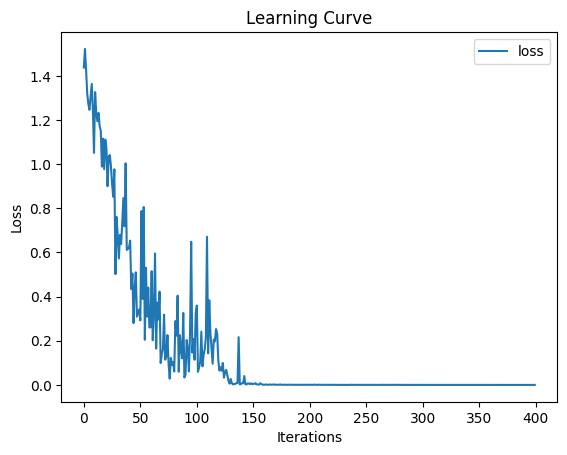

In [169]:
def train(num_epochs, model, train_loader, loss_function):
    total_step = len(train_loader)
    
    for epoch in range(num_epochs):
        for batch, (lifts, labels) in enumerate(train_loader):
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            loss = loss_function(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (batch+1) % 2 == 0:
                loss_list.append(loss.item())
                print(f"Epoch [{epoch+1}; Batch {batch+1}/{total_step}]; Loss: {loss.item():.4f}")
                
loss_list = []
#draw learning curve
def plot_learning_curve(loss_list):
    plt.plot(loss_list, label="loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
train(num_epochs, model, train_loader, loss_function)
plot_learning_curve(loss_list)


In [170]:
def validate(model, val_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in val_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Validation accuracy: {100 * correct / total}%")

validate(model, val_loader)

Validation accuracy: 22.727272727272727%


In [171]:
def test(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for lifts, labels in test_loader:
            lifts = lifts.reshape(-1, sequence_len, input_len).to(device)
            labels = labels.long().to(device)
            
            outputs = model(lifts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Test accuracy: {100 * correct / total}%")

test(model, test_loader)

Test accuracy: 29.166666666666668%
